# Прогнозирование вероятности оттока пользователей для фитнес-центров (Churn Prediction for Fitness Centers)

## Описание проекта

Проблема фитнес-центров - отток клиентов. Имеются данные о клиентах сети фитнес-центров.

**Цель проекта:** на основе данных о посетителях сети фитнес-центров провести анализ и подготовить план действий по удержанию клиентов.

**Задачи проекта:**

* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента,
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства,
* проанализировать основные признаки, наиболее влияющие на отток,
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

**Описание данных**

Данные о клиентах находятся в файле `gym_churn.csv`, где:

Данные клиента за предыдущий до проверки факта оттока месяц:
    
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
    
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

    `Churn` — факт оттока в текущем месяце.


## Исследовательский анализ данных (EDA)

### Предобработка и первичный анализ данных

Импортируем библиотеки для дальнейшего исследования

In [1]:
# исследовательский анализ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# подготовка и стандартизация данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# обучение моделей ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# расчет метрик моделей
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# обучение ML-модели кластеризации
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# предупреждения и внешний вид
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None 
pd.set_option('display.max_colwidth', -1)

Загрузим данные и получим информацию о данных. Создадим функцию `df_read_csv`, которая выведит сообщение об ошибке, если информация о файле будет указана неверно

In [2]:
def df_read_csv(path, sep=','):
    try:
        return pd.read_csv(path, sep)
    except Exception:
        print('Ошибка при загрузке файла')
df = df_read_csv('gym_churn.csv', sep=',')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Проверим данные на пропуски и явные дубликаты

In [3]:
print("Количество пропущенных значений: {}".format(df.isnull().sum().sum())) 
print("Количество дубликатов: {}".format(df.duplicated().sum()))             

Количество пропущенных значений: 0
Количество дубликатов: 0


Пропусков не обнаружено. Но Python показывает пустые значения только, если оно имеет тип `NoneType`. Необходимо проверить, есть ли другие пропуски в столбцах. Для этого создадим функцию `nan_values`.

In [4]:
# функция для вывода пропущенных значений
def nan_values(df,list_nans = ['',' ','""', '" "', None, np.nan]):
    list_count = []
    list_share = []
    for col in df.columns:
        list_count.append(sum(df[col].isin(list_nans)))
        list_share.append(round(sum(df[col].isin(list_nans)) * 100 / len(df), 2))
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'num_missing': list_count, 'percent_missing': list_share})
    return missing_value_df
nan_values(df) # применение функции для таблицы 

,column_name,num_missing,percent_missing
0,gender,0,0.0
1,Near_Location,0,0.0
2,Partner,0,0.0
3,Promo_friends,0,0.0
4,Phone,0,0.0
5,Contract_period,0,0.0
6,Group_visits,0,0.0
7,Age,0,0.0
8,Avg_additional_charges_total,0,0.0
9,Month_to_end_contract,0,0.0


Приведем наименования столбцов к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Приведем столбец `month_to_end_contract` к целочисленному типу, т.к. в нем указано целое число месяцев до окончания текущего действующего абонемента

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Проведем первичный анализ данных:

* мужчин и женщин среди клиентов приблизительно одинаковое количество;

* 84% всех клиентов живут или работают в районе, где находится фитнес-центр;

* примерно половина клиентов — сотрудники компании-партнёра клуба;

* почти треть клиентов пришли в рамках акции «приведи друга», что является неплохим показателем;

* у большинства клиентов (90%) указан номер телефона - хороший показатель, остальные 10%, возможно, не хотят предоставлять лишние персональные данные; 

* средняя продолжительность контракта 4.7 месяца кажется неплохим показателем, но медианное значение – 1 месяц; возможно, многие люди пользуются акциями и только пришли в фитнес-клуб;

* 41% всех клиентов посещают групповые занятия, возможно это связано с дополнительными скидками или акциями;

* средний возраст совпадает с медианным – 29 лет, вся аудитория - 18 - 41 год, клуб обладает достаточно молодой аудиторией;

* неплатящие за дополнительные услуги клуба клиенты отсутствуют;

* срок до конца абонемента практически не отличается от длительности абонемента, возможно все клиенты их недавно приобрели или продлили;

* среднее время с момента первого обращения в фитнес-центр менее 4 месяцев, при том, что как минимум 1 клуб сети открыт не менее 2.5 лет (31 месяц);

* в среднем клиенты тренируются 1-2 раза в неделю, но есть и те, кто тренируется 6 раз в неделю;

* средний отток 27%. Этот показатель является важнейшим для нас. Анализом оттока займемся далее.

### Анализ признаков по группам

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (1 - те, кто ушел и 0 - те, кто остался)

In [8]:
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Составим предположения о клиентах, ушелших в отток:

* треть клиентов пользуются партнерской программой клуба;
* абонементы покупают на короткий срок (не более 2 месяцев);
* чаще занимаются одни, 1-2 раза в неделю.

### Гистограммы признаков

Разделим исходный датасет на 2 по признаку оттока `churn`. Построим гистограммы по всем признакам, где наглядно будет видно сравнение двух групп. Разделим все признаки на количественные и категориальные

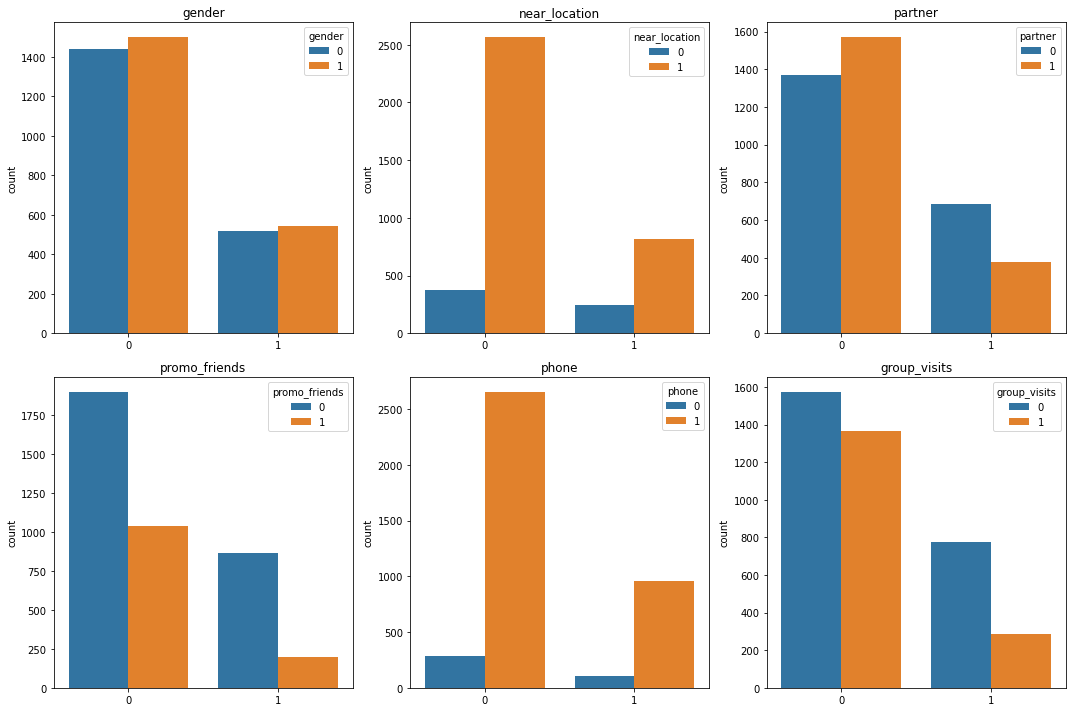

In [9]:
# Выделим категориальные признаки;
# делаем новых холст в котором графики будут в 3 столбца, а число строк - количество признаков деленное на 3

cat = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

number_row = int(len(cat)/3)
fig, ax = plt.subplots(nrows=number_row, ncols=3, figsize=(15, 10))

# вытягиваем в один ряд
ax = ax.flatten() 

for i in range(len(cat)):
    sns.countplot(x='churn', data=df, hue=cat[i], ax=ax[i])
    ax[i].set_title(f'{cat[i]}')
    ax[i].set_xlabel('')
                
# полное отображение записей    
fig.tight_layout()
fig.show()

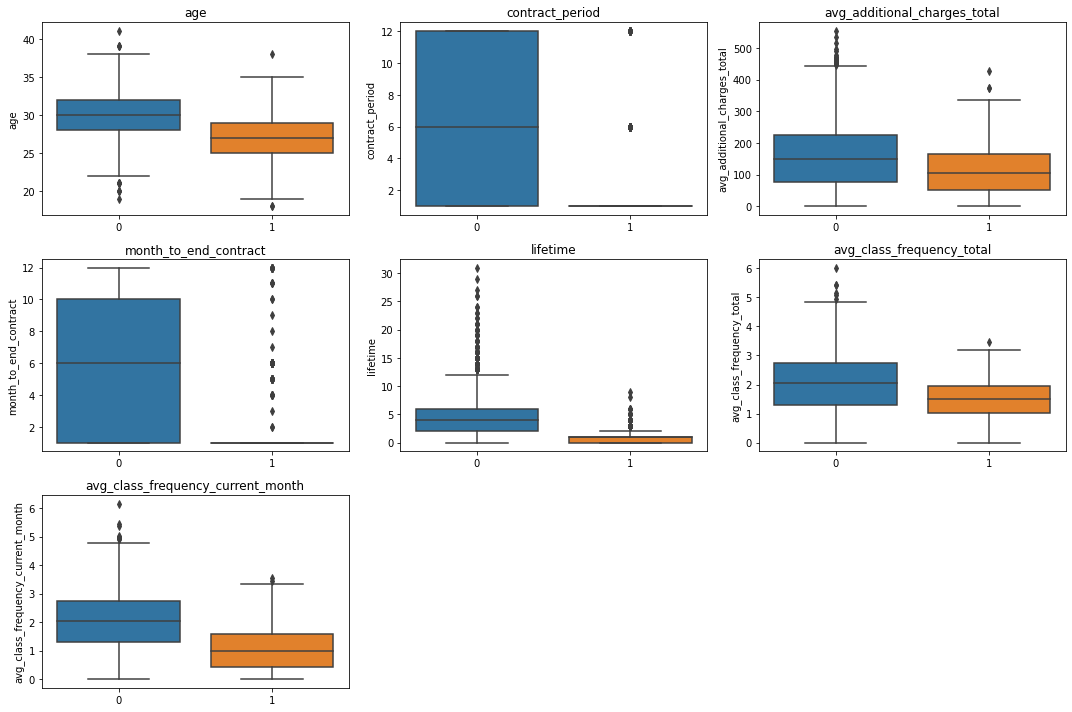

In [10]:
# Выделим количественные признаки;
# делаем новых холст в котором графики будут в 3 столбца, а число строк - количество признаков деленное на 3

count = ['age', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
         'avg_class_frequency_total', 'avg_class_frequency_current_month']

number_row = int(len(count)/3)
fig, ax = plt.subplots(nrows=number_row+1, ncols=3, figsize=(15, 10))

# вытягиваем в один ряд
ax = ax.flatten() 

for i in range(len(count)):
    sns.boxplot(y = count[i], x = 'churn', data = df, ax=ax[i])
    ax[i].set_title(f'{count[i]}')
    ax[i].set_xlabel('')
    
# удаляем 2 пустых графика
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
            
# полное отображение записей    
fig.tight_layout()
fig.show()

Графики подтверждают выводы прошлого раздела. Также можно добавить следующее:

* клиенты, живущие не в районе фитнес-клуба, чаще уходят;
* люди, пришедшие по приглашению друзей в рамках акции, уходят реже.

### Матрица корреляций

Построим матрицу корреляций

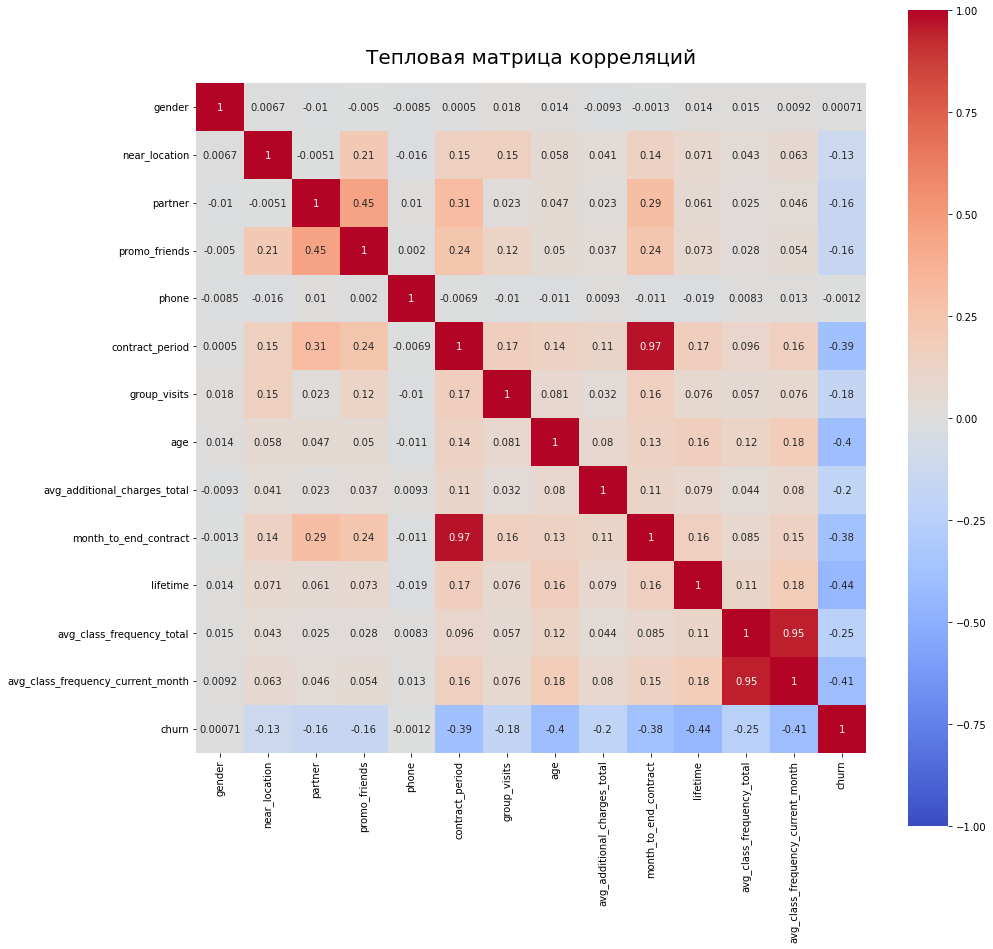

In [11]:
corr_m = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True, vmin = -1, vmax = 1, cmap='coolwarm')
plt.title('Тепловая матрица корреляций', fontsize=20, pad=20)
plt.show()

Проанализируем матрицу корреляций.  Признаков, сильно коррелирующих с фактом оттока нет (максимум: 0.44).

Большинство признаков имеют слабую корреляционную (линейную) связь между собой. Но стоит отметить 2 пары признаков: `avg_class_frequency_current_month` и `avg_class_frequency_total`,  и `month_to_end_contract`, у которых корреляция 0.95 и 0.97, соответственно. Чтобы избежать мультиколлинеарности и построить более точную модель, оставим только один из признаков в паре. Удалим `avg_class_frequency_current_month` и `contract_period` из данных.

In [12]:
df_new = df.drop(['avg_class_frequency_current_month', 'contract_period'], axis = 1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        4000 non-null   int64  
 1   near_location                 4000 non-null   int64  
 2   partner                       4000 non-null   int64  
 3   promo_friends                 4000 non-null   int64  
 4   phone                         4000 non-null   int64  
 5   group_visits                  4000 non-null   int64  
 6   age                           4000 non-null   int64  
 7   avg_additional_charges_total  4000 non-null   float64
 8   month_to_end_contract         4000 non-null   int64  
 9   lifetime                      4000 non-null   int64  
 10  avg_class_frequency_total     4000 non-null   float64
 11  churn                         4000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


## Построение модели прогнозирования оттока клиентов

Решаемая задача - **бинарная классификция**, т.к. нам необходимо спрогнозировать отток клиентов, которые либо может состояться, либо нет.

Обучать модель будем на основе датасета `df_new`, где имеем целевую переменную `churn` и 11 признаков.

Обучать модель будем двумя способами: 

* **Логистическая регрессией**,
* **Cлучайным лесом**.

Оценивать модели будем по 4 метрикам:

* **Accuracy** - доля правильных ответов
* **Precision** - точность модели. Показывает долю правильных ответов только среди целевого класса
* **Recall** - полнота модели. Показывает, сколько реальных фактов ухода клиента удалось обнаружить с помощью модели
* **F1-мера** -  сводная метрика, учитывающая баланс между метриками Precision и Recall

Разделим данные на **обучающую и валидационную выборку** в соотношении **80/20**, а также стандартизируем данные.

In [13]:
# разделение на признаки и целевую переменной
X = df_new.drop('churn', axis = 1)
y = df_new['churn']

# выделение обучающей и валидационной выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.2)

# создание объекта класса StandardScaler и применение к обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# стандартизация признаков для моделей
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Сформируем модели и выведим значения метрик для каждой из них

In [14]:
# формирование списка моделлей
models = [LogisticRegression(solver = 'liblinear', random_state = 0),
          RandomForestClassifier(n_estimators = 100, random_state = 0)
         ]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    
    # задание и обучение моделей
    model = m                     
    model.fit(X_train, y_train)
    
    # прогнозирование целевой переменной и вероятности
    predictions = model.predict(X_test)
    
    # вывод метрик
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

# цикл, который выводит метрики по списку моделей
for i in models:
    print('Модель:', i)
    make_prediction (i,X_train, y_train, X_test, y_test)
    print('')

Модель: LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.88
Precision: 0.76
Recall: 0.77
F1: 0.77

Модель: RandomForestClassifier(random_state=0)
Accuracy: 0.90
Precision: 0.80
Recall: 0.77
F1: 0.79



По полученным результатам можно сказать, что лучше себя проявила модель, обученная алгоритмом **"Случайный лес"**. Параметры **Accuracy, Precision и F1** у нее выше, чем у модели, обученной алгоритмом **"Логистическая регрессия"**, а метрика **Recall** одинаковая.

## Кластеризация клиентов

### Построение дендрограммы и определение количества кластеров

Нам необходимо сегментировать клиентов, т.е. определить наиболее склонных к оттоку. Это задача кластеризации, обучение "без учителя".

Стандартизируем общий набор данных и построим дендрограмму с разделением по кластерам

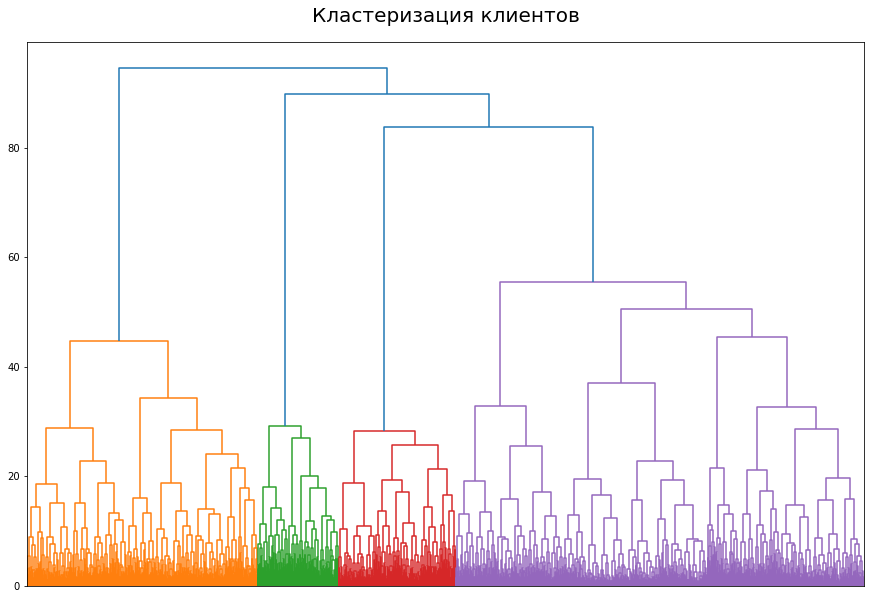

In [15]:
# создание и обучение стандартизатора, стандартизация данных
X_st = StandardScaler().fit_transform(X)

# матрица расстояний
linked = linkage(X_st, method='ward')

# дендрограмма
plt.figure(figsize=(15,10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеризация клиентов', size=20, pad=20)
plt.show()

Дендрограмма предложила 4 кластера, которые существенно различаются количеством клиентов. В соответствии с условиями проекта, выделяем 5 отдельных кластеров для будущего обученмя модели.

### Обучение модели кластеризации

Обучим модель кластеризации на основании алгоритма **K-Means** и спрогнозируем кластеры клиентов. Алгоритм основан на предположении, что число кластеров заранее известно.

In [16]:
# задание модели кластеризации
km_model = KMeans(n_clusters = 5, random_state = 0)

# обучение модели и получение кластеров по каждому клиенту
labels = km_model.fit_predict(X_st)

# занесение номера кластера в датасет
df['km_cluster'] = labels

Выведим количество клиентов по кластерам

In [17]:
df.groupby('km_cluster')['churn'].count()

km_cluster
0    1001
1    557 
2    898 
3    1158
4    386 
Name: churn, dtype: int64

### Анализ кластеров

Посмотрим на средние значения признаков в каждом кластере

In [18]:
cluster_features = df.groupby('km_cluster').mean()
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

km_cluster,0,1,2,3,4
gender,0.50,0.50,0.52,0.51,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.42,0.20,0.47
promo_friends,1.00,0.08,0.01,0.05,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.84,2.98,6.73,2.01,4.78
group_visits,0.52,0.23,0.55,0.30,0.43
age,29.54,28.69,30.81,27.82,29.30
avg_additional_charges_total,152.14,137.28,177.10,124.63,144.21
month_to_end_contract,6.27,2.80,6.16,1.90,4.47


Проанализируем полученные данные.

**Кластер 0**

* Уходят 13% клиентов
* Почти все клиенты работают или живут рядом с клубом
* 89% клиентов пришли по партнерской программе (наивысший показатель)
* Все клиенты первый раз пришли в рамках акции «приведи друга», т.е. по рекомендации друзей (наивысший показатель)
* Клиенты покупают абонементы на длительный срок (12 месяцев). Такое предположение можно сделать исходя из того, что средний срок до окончания текущего действующего абонемента `month_to_end_contract` - 6.3 мес., а среднее время с момента первого обращения в фитнес-центр `lifetime` - 4.2 мес.. Это подтверждается средней длительностью текущего действующего абонемента `contract_period` - 6.8 мес., что больше 6 месяцев.
* 52% клиентов посещают групповые занятия
* Посещают клуб примерно 2 раза в неделю

**Кластер 1**

* Уходят 40% клиентов
* Все клиенты живут или работают далеко от клуба (наименьший показатель)
* 49% клиентов пришли по партнерской программе
* 7% клиентов пришли первый раз по рекомендации друзей
* Клиенты покупают абонементы на средний срок (6 месяцев). `month_to_end_contract` - 2.8 мес., `lifetime` - 2.9 мес., `contract_period` - 2.9 мес.
* 23% клиентов посещают групповые занятия (наименьший показатель)
* Посещают клуб примерно 2 раза в неделю

**Кластер 2**

* Уходят всего 1.6% клиентов (наименьший показатель)
* Почти все клиенты работают или живут рядом с клубом
* 42% клиентов пришли по партнерской программе
* 1% клиентов пришли первый раз по рекомендации друзей (наименьший показатель)
* Клиенты покупают абонементы на длительный срок (12 месяцев). `month_to_end_contract` - 6.2 мес., `lifetime` - 5.7 мес., `contract_period` - 6.7 мес.
* 55% клиентов посещают групповые занятия (наивысший показатель)
* Посещают клуб примерно 2 раза в неделю (наивысшей показатель)

**Кластер 3**
* Половина (50%) клиентов уходят (наивысшей показатель)
* Все клиенты работают или живут рядом с клубом (наивысшей показатель)
* 20% клиентов пришли по партнерской программе (наименьший показатель)
* 5% клиентов пришли первый раз по рекомендации друзей
* Клиенты покупают абонементы на короткий или средний срок (1 или 6 месяцев). `month_to_end_contract` - 1.9 мес., `lifetime` - 2 мес., `contract_period` - 2 мес. В данном случае есть предположение, что в кластере достаточное количество клиентов, покупающих аботнементы на 1 месяц, а также те, кто закрывают свои средние абонементы раньше срока.
* 30% клиентов посещают групповые занятия
* Посещают клуб примерно 1-2 раза в неделю

**Кластер 4**

* Уходят 27% клиентов
* 86% клиентов живут или работают рядом с клубом
* 47% клиентов пришли по партнерской программе
* 31% клиентов пришли первый раз по рекомендации друзей
* Клиенты покупают абонементы на длительный срок (12 месяцев). `month_to_end_contract` - 4.5 мес., `lifetime` - 3.9 мес., `contract_period` - 4.8 мес.
* 43% клиентов посещают групповые занятия
* Посещают клуб примерно 1-2 раза в неделю

Основные выводы и замечания по кластерам:

* **0 и 2 кластеры** являются самыми надежными. В них наименьший отток клиентов, место работы или проживания клиентов находятся рядом с финтес-центром, абонименты покупают на длительный срок, посещают клуб примерно 2 раза в неделю
* **1 кластер** с не самымы лояльными клиентами, но это объяснимо тем, что все клиенты живут или работают далеко от клуба, поэтому в оттоке 40% нет ничего удивительного
* **4 кластер** кажется стабильным, все показатели средние, но проценти оттока хотелось бы уменьшить
* **3 кластер** выглядит аномальным. Половина всех клиентов уходят, хотя все они работают или живут вблизи центра, абонементы покупают на короткий или средний срок, возможно разрывают их и уходят раньше
    
Пол, наличие номера телефона, возраст и средний чек по дополнительным услугам примерно одинаковый во всех кластерах.



### Построение распределения признаков

Построим диаграммы распределения признаков для кластеров. Для категориальных признаков используем для визуализации гистограммы, для количественных - график "ящик с усами".

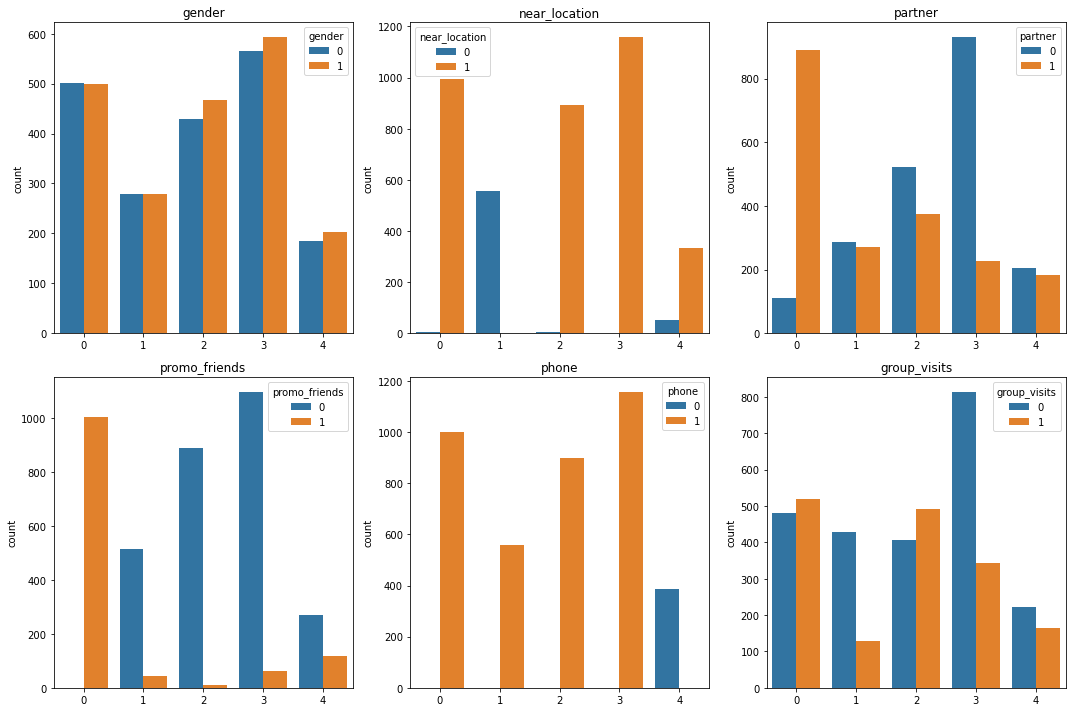

In [19]:
# Выделим категориальные признаки
cat = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

number_row = int(len(cat)/3)
fig, ax = plt.subplots(nrows=number_row, ncols=3, figsize=(15, 10))

# вытягиваем в один ряд
ax = ax.flatten() 

for i in range(len(cat)):
    sns.countplot(x='km_cluster', data=df, hue=cat[i], ax=ax[i])
    ax[i].set_title(f'{cat[i]}')
    ax[i].set_xlabel('')
                
# полное отображение записей    
fig.tight_layout()
fig.show()

Выводы из предыдущего пункта подтверждаются и по графикам распределения.

* По гендерному признаку отличий между кластерами нет
* В 1 клаастере нет клиентов проживающих или работающих в районе клуба, по остальным кластерам ситуация противоположная, практически 100% клиентов проживают или работают в непосредственной близости;
* Больше всего клиентов по партнерской программе сосредоточено в 0 кластере, больше всего не по программам - в кластере 3
* Клиентов, пришедших в рамках акции «приведи друга» больше всего кластере 0, меньше всего - в кластере 3
* Номер телефона указан у клиентов всех кластеров кроме 4, где все клиенты заботятся о своей конфиденциальности
* Реже всего посещают групповые занятия клиенты кластера 3

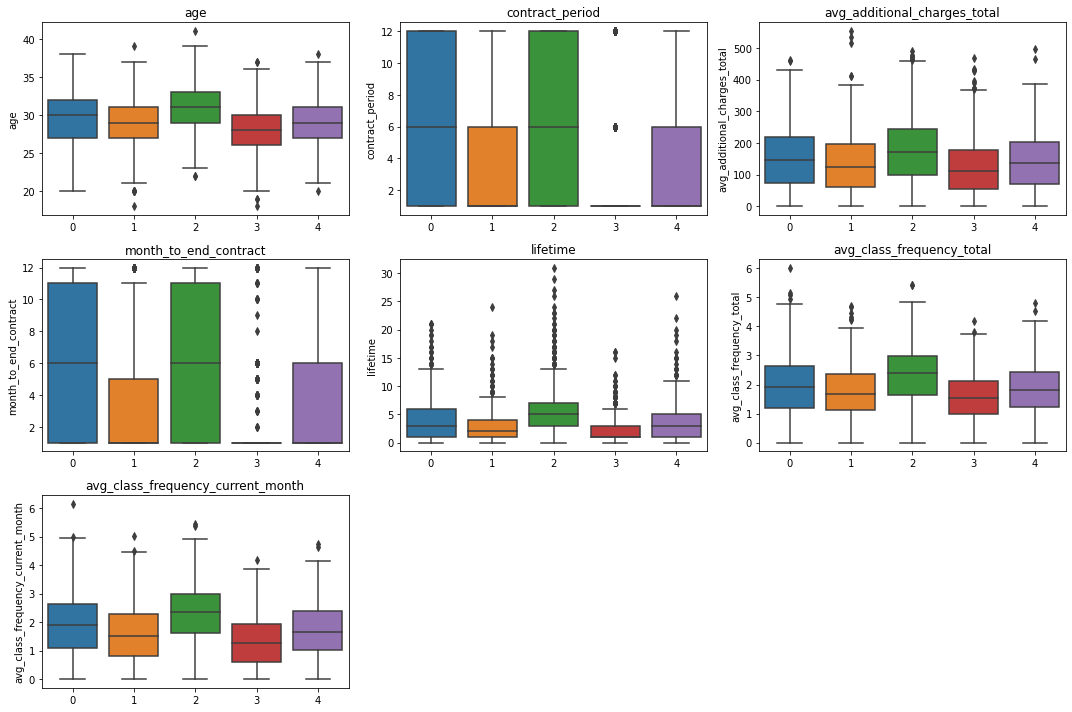

In [20]:
# Выделим количественные признаки
count = ['age', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
         'avg_class_frequency_total', 'avg_class_frequency_current_month']

number_row = int(len(count)/3)
fig, ax = plt.subplots(nrows=number_row+1, ncols=3, figsize=(15, 10))

# вытягиваем в один ряд
ax = ax.flatten() 

for i in range(len(count)):
    sns.boxplot(y = count[i], x = 'km_cluster', data = df, ax=ax[i])
    ax[i].set_title(f'{count[i]}')
    ax[i].set_xlabel('')
    
# удаляем 2 пустых графика
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
            
# полное отображение записей    
fig.tight_layout()
fig.show()

По этим признакам также подтверждаются выводы из предыдущего пункта:

* Средний возраст клиентов 0, 1 и 4 кластеров - 30 лет, наименьший показатель в кластере 3 - 27 лет, наивысший в кластере 2 - 32 года;
* Чаще всего покупают короткие абонементы на 1 месяц клиенты икластера 3, а в кластерах 0 и 2 большая часть абонементов на 12 месяцев
* Средняя суммарная выручка от других услуг фитнес-центра во всех кластерах примерно одинаковая, чуть выше у кластера 2
* Средний срок до окончания текущего действующего абонемента наивысший в кластерах 0 и 2 - 6 месяцев, а наименьший у кластера 3 - 1 месяц, этот кластер выглядит аномальным
* Среднее время с момента первого обращения в фитнес-центр у кластеров 0, 2, 4
* Чаще всего тренируются клиенты из кластера 2, но в целом этот показатель во всех кластерах примерно одинаков - 2 раза в неделю

Если сопоставить все выводы, можно сказать, что самыми **привлекательными** выглядят **кластеры 0 и 2**, самым непоказательным - класс 3.

### Доля оттока по кластерам

Посчитаем долю оттока по кластерам, хотя до этого мы уже видели эту информацию (кластеры 0 и 2 - меньше всего оттока, кластер 3 - большего всего оттока)

In [21]:
df.groupby('km_cluster').agg({'churn':'mean'}).sort_values('churn').style.format('{:.1%}')

,churn
km_cluster,
2,1.7%
0,13.3%
4,26.7%
1,40.2%
3,50.6%


* Половина клиентов кластера 3 уходят
* Кластер 1 также имеет плохой процент оттока - 40%
* Самый надежный кластер 2, в котором ухолят меньше 2% клиентов
* Кластер 0 выглядит стабильно - 13% клиентов уходят



## Выводы и рекомендации

В работе было проведено исследовние данных о посетителях сети фитнес-центров, чтобы проанализировать основные признаки, наиболее влияющие на отток. 

По результатам анализа можно сделать следующие выводы и рекомендации:

* признаков, сильно коррелирующих с фактом оттока нет, что мы увидели с помощью матрицы корреляций. Средняя корреляция наблюдается между оттоком `churn` и длительностью текущего действующего абонемента (`contract_period`), возрастом клиентов (`age`), сроком до окончания текущего действующего абонемента (`month_to_end_contract`), временем с момента первого обращения в фитнес-центр (`lifetime`), средней частотой посещений в неделю за предыдущий месяц (`avg_class_frequency_current_month`)
* построив модели прогнозирования оттока клиентов двумя методами: логистическая регрессией и случайным лесом, оценили выбранные метрики **Accuracy, Recall, Precision и F1**, которые оказались лучше у модели, обученной алгоритмом **"Случайный лес"**, но незначительно. Обе модели показали хороший результат
* сегментировав клиентов, выделили 5 кластеров. Обучение модели кластеризации производилось на основании алгоритма **K-Means** 
* **2 кластер** выявлен самым надежным. В нем наименьший процент оттока (<2%), почти все клиенты живут или работают рядом с центром, абонементы покупают на длительный срок (12 мес.), посещают занятия 2 раза в неделю, больше половины предпочитают групповые занятия
* **0 кластер** является самым стабильным. Процент оттока приемлимый (13%), центр располагается рядом с местом работы или проживания, 89% клиентов являются партнерами центра, все клиенты пришли в рамках акции "приведи друга", больше половины посещают групповые занятия, в среднем тренируются 2 раза в неделю и покупают абонементы на 12 мес.
* **3 кластер** является самым ненадеждым. Половина клиентов уходят, большая часть абонементов приобретена на 1 мес., клиенты посещают занаятия 1 раз в неделю. Это могла бы объясняться расположением центра, но в этом кластере все клиенты живут или работают рядом с клубом.
* **1 кластер** обладает оттоком в 40%. Это можно объяснить в первую очередь расположением клуба, т.к. он расположен далеко от работы или места жительства клиентов.
* в качестве рекомендации можно предложить расширить возрастную аудиторию, например, засчет дополнительных групповых занятий. Клиенты этой сети в возрасте от 18 до 41 года. Молодые люди часто меняют свой образ жизни и интересов, а более старшее поколение стабильнее ведет образ жизни.
* стоит дополнительно поработать с кластером 3, т.к. в нем собрано больше всего клиентов. Стоит попробовать ввести скидки при покупке более длительных абонементов.